#### Chain Of Thoughts With RAG
What is Chain-of-Thought (CoT) in RAG?

CoT reasoning breaks down a complex question into intermediate steps, and allows retrieval + reflection at each step before answering.

User Query
   ↓
- Step 1: Decompose question → sub-steps (Reason)
- Step 2: Retrieve docs per step (Act)
- Step 3: Combine context (Observe)
- Step 4: Final answer generation (Reflect)

In [3]:
import os
from typing import List
from pydantic import BaseModel
from langchain.schema import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

In [4]:
# -------------------------------
# 1. Prepare Vectorstore
# -------------------------------
docs = TextLoader("research_notes.txt",encoding="utf-8").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

## Initialize a simple Embedding model(no API Key needed!)
embeddings=HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

c:\Users\ChitreshKaushik\Documents\RAG_UseCases\RAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="openai/gpt-oss-120b")

In [6]:
# -------------------------------
# 2. LangGraph State Definition
# -------------------------------
class RAGCoTState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [7]:
# -------------------------------
# 3. Nodes
# -------------------------------

# a. Plan sub-questions
def plan_steps(state:RAGCoTState)->RAGCoTState:
    prompt=f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps":subqs})


In [8]:
# b. Retrieve for each step
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})


In [12]:
# c. Generate Final Answer
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
                You are answering a complex question using reasoning and retrieved documents.

                Question: {state.question}

                Relevant Information:
                {context}

                Now synthesize a well-reasoned final answer.
            """
    
    result = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": result})

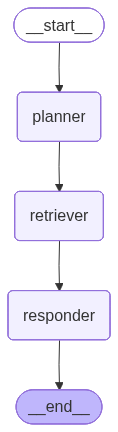

In [13]:
# -------------------------------
# 4. LangGraph Graph
# -------------------------------
builder = StateGraph(RAGCoTState)
builder.add_node("planner", plan_steps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [11]:
# -------------------------------
# 5. Run CoT RAG Agent
# -------------------------------
if __name__ == "__main__":
    query = "what are the additional eperiments in Transformer eveluation?"
    state = RAGCoTState(question=query)
    final = graph.invoke(state)

    print("\n🪜 Reasoning Steps:", final["sub_steps"])
    print("\n✅ Final Answer:\n", final["answer"])


🪜 Reasoning Steps: ['**Step\u202f1 – Identify the context of “additional experiments.”**', 'First, determine which study or benchmark is being referenced when the phrase “Transformer evaluation” is used. In most recent NLP literature, “additional experiments” usually refer to the supplementary analyses that authors include beyond the core set of baseline comparisons (e.g., ablation studies, scaling curves, robustness checks, or downstream‑task fine‑tuning). Pinpoint the exact paper or report (for example, *“Attention Is All You Need,” “BERT: Pre‑training of Deep Bidirectional Transformers,”* or a more recent evaluation suite such as the *GLUE* or *SuperGLUE* benchmark) so you know which “additional experiments” are meant.', '**Step\u202f2 – Enumerate the specific extra experiments reported.**', 'Once the source is clear, list the extra experiments that the authors performed beyond the primary results. Typical categories include:', '| Category | Typical experiments labeled “additional”